In [1]:
cd /home/tvangraft/tudelft/thesis/metaengineering

/home/tvangraft/tudelft/thesis/metaengineering


In [2]:
import pickle
import glob
import itertools
from typing import List, Callable

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from src.settings.tier import Tier
from src.settings.strategy import Strategy

from src.utils.utils import get_generator, get_project_root, make_path_if_not_exists, load_model

In [3]:
MODE = 'talk'
FIGSIZE = (0, 0)
DPI = 0

# Paper dimensions

# Presentation dimensions
LABEL_SIZE_TALK = 16
DPI_TALK = 96
FIGSIZE_TALK = (13.33, 7.5)
FONTSIZE_TALK = 18

In [4]:
def get_lime_df(tier: Tier, strategy: Strategy):
    paths = get_explanation_paths("lime", tier, strategy)
    df = pd.concat([pd.read_json(path) for path in paths])
    return df

def get_shap_df(tier: Tier, strategy: Strategy):
    paths = get_explanation_paths("shap", tier, strategy)

    pickled_explanations = {}

    for path in paths:
        with open(path, mode='rb') as shap_explanation:
            clean_path = path.replace(f"/home/tvangraft/tudelft/thesis/metaengineering/explanation/{tier}/shap/{strategy}_", "").replace(".pickle", "")
            pickled_explanations[clean_path] = pickle.load(shap_explanation)

    return pickled_explanations

def get_explanation_paths(type: str, tier: Tier, strategy: Strategy):
    explanation_path = f"/home/tvangraft/tudelft/thesis/metaengineering/explanation/{tier}/{type}"
    paths = glob.glob(f"{explanation_path}/{strategy}_*")
    return paths

def set_context(mode):
    if mode == 'talk':
        sns.set_context(
            "talk",
            rc={
                "font_size": FONTSIZE_TALK,
                "axes.labelsize": LABEL_SIZE_TALK,
            }
        )
        fig = plt.figure(figsize=FIGSIZE_TALK, dpi=DPI_TALK)
        return fig

def save_fig(path: str, name: str):
    make_path_if_not_exists(path)
    plt.savefig(f"{path}/{name}.png", bbox_inches='tight')
    plt.savefig(f"{path}/{name}.svg", bbox_inches='tight')
    
df = get_lime_df(tier=Tier.TIER0, strategy=Strategy.METABOLITE_CENTRIC)
shap_explanations = get_shap_df(tier=Tier.TIER0, strategy=Strategy.METABOLITE_CENTRIC)

In [5]:
def count_overlap(enzymes_one: List, enzymes_two: List):
    idx = 20
    return len(set(enzymes_one[:idx]) & set(enzymes_two[:idx])) / len(enzymes_one[:idx])

def kendalltau(enzymes_one: List, enzymes_two: List):
    from scipy.stats import kendalltau
    return kendalltau(enzymes_one, enzymes_two)[0]

def rank_correlation_metabolite_id(df: pd.DataFrame, metabolite_id: str, agg_func):
    _df = df[df['metabolite_id'] == metabolite_id].set_index('KO_ORF')
    return rank_correlation(_df, agg_func)

def rank_correlation_knockout(df: pd.DataFrame, knockout_id: str, agg_func):
    _df = df[df['KO_ORF'] == knockout_id].set_index('metabolite_id')
    return rank_correlation(_df, agg_func)

def rank_correlation_all(df: pd.DataFrame, agg_func: Callable):
    _df = df.reset_index()
    return rank_correlation(_df, agg_func)

def rank_correlation(_df: pd.DataFrame, agg_func: Callable):
    unique_knockouts = _df.index.to_list()
    knockout_combinations = list(itertools.combinations(unique_knockouts, r=2))
    
    n = len(unique_knockouts)
    r = np.ones((n, n))
    triu = np.triu_indices(n, 1)
    tril = np.tril_indices(n, -1)
    
    key = 'exp_enzymes'
    kendalltau_correllation = [agg_func(_df.loc[left_knockout][key], _df.loc[right_knockout][key]) for (left_knockout, right_knockout) in knockout_combinations]
    
    r[triu] = kendalltau_correllation
    r[tril] = r.T[tril]
    
    return r, unique_knockouts



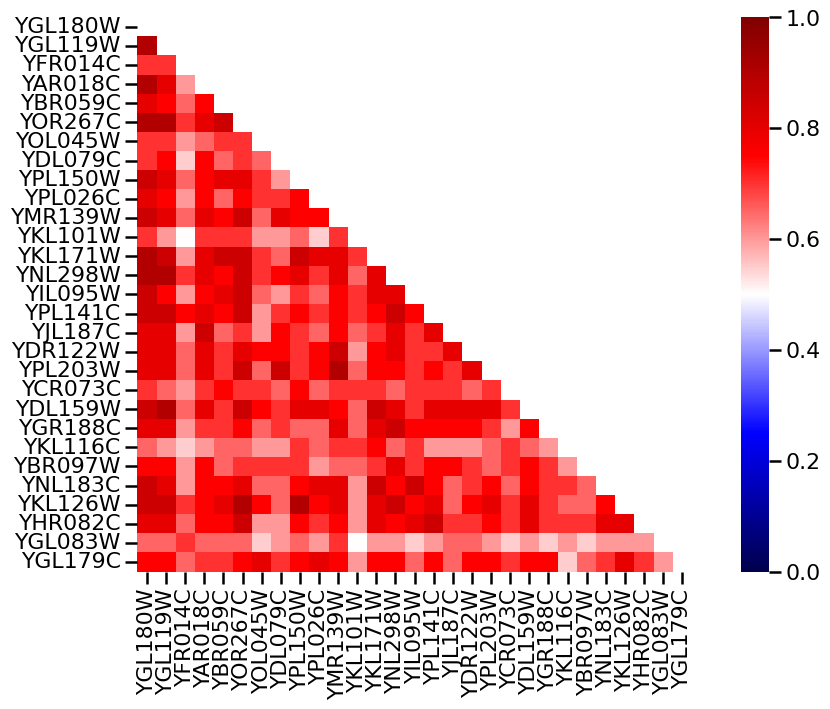

In [6]:
df = get_lime_df(tier=Tier.TIER0, strategy=Strategy.ALL)
figure = set_context(MODE)
ax = figure.add_subplot(1, 1, 1)
unique_metabolite_id = 'pep'
correlation_matrix, knockouts = rank_correlation_metabolite_id(df, unique_metabolite_id, count_overlap)
sns.heatmap(
    correlation_matrix, 
    square=True, 
    # annot=True,
    # fmt=".2f",
    vmax=1,
    vmin=0,
    ax=ax,
    xticklabels=knockouts,
    yticklabels=knockouts,
    cmap="seismic",
    mask=np.triu(correlation_matrix),
    # cbar=False,
)
plt.savefig(f"./{unique_metabolite_id}.png")
save_fig(path=f'./images/{MODE}/explanation/', name="pyruvate_count_overlap")

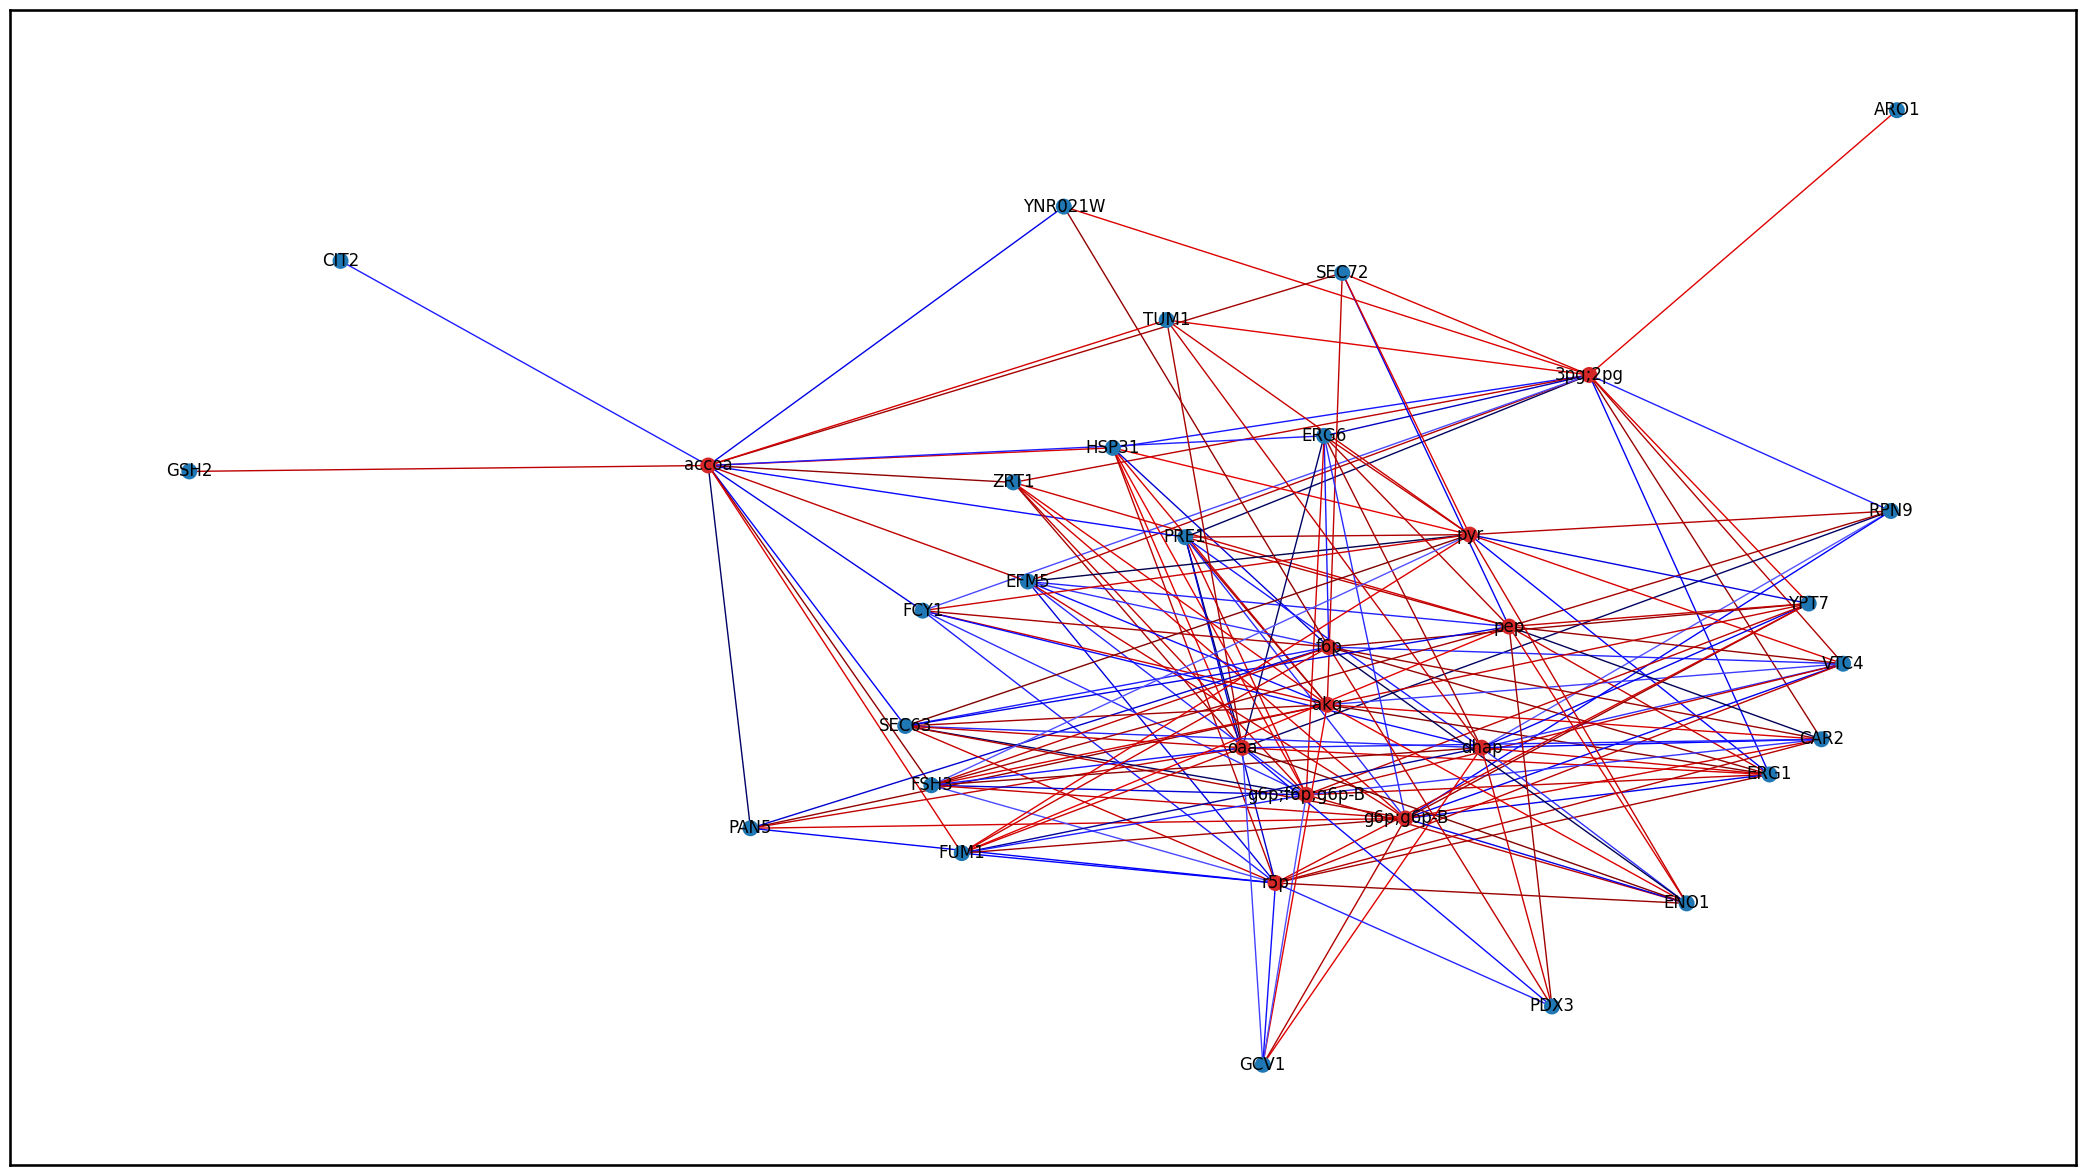

In [7]:
import networkx as nx

# fig = set_context(MODE)
fig = plt.figure(figsize=(FIGSIZE_TALK[0] * 2, FIGSIZE_TALK[1] * 2))
axgrid= fig.add_gridspec(6, 4)

NROWS, NCOLS = 6, 4
LOWER, MIDDLE, UPPER = int(NROWS / 3), int(2 * NROWS / 3), NROWS
LEFT, RIGHT = int(NCOLS / 2), NCOLS

ax0 = fig.add_subplot(axgrid[:, :])

df = get_lime_df(tier=Tier.TIER0, strategy=Strategy.ALL)
df = df[['metabolite_id', 'exp_enzymes', 'exp_weights']].explode(column=['exp_enzymes', 'exp_weights'])
df = df.groupby(by=['metabolite_id']).head(15).groupby(by=['metabolite_id', 'exp_enzymes']).aggregate(['mean', 'count']).reset_index()

enzyme_nodes = df['exp_enzymes'].unique()
metabolite_nodes = df['metabolite_id'].unique()

lime_explaination_graph = nx.from_pandas_edgelist(df, source='exp_enzymes', target='metabolite_id')
protein_info = pd.read_json("/home/tvangraft/tudelft/thesis/metaengineering/data/training/gene_annotation.json").T.explode('gene_prefered_name').reset_index(names=['orf'])
orf_to_human = protein_info[['orf', 'gene_prefered_name']].set_index('orf').to_dict()['gene_prefered_name']

lime_explaination_graph = nx.relabel_nodes(lime_explaination_graph, orf_to_human)
# pos = nx.nx_agraph.graphviz_layout(lime_explaination_graph)
pos = nx.kamada_kawai_layout(lime_explaination_graph)
pos = nx.rescale_layout_dict(pos, .1)
color_map = ["tab:blue" if node not in metabolite_nodes else "tab:red" for node in lime_explaination_graph]



nx.draw_networkx(
    lime_explaination_graph,
    pos = pos,
    node_size=100,
    ax=ax0,
    node_color=color_map,
    edge_cmap=plt.cm.seismic,
    edge_color=df[('exp_weights', 'mean')].values
)

# from pyvis.network import Network
# net = Network()
# net.from_nx(lime_explaination_graph)
# net.show("example.html")

In [73]:
from src.utils.stoichiometry_to_graph import get_gene_reaction, is_precursor_metabolite, get_matching_precursor_metabolite, get_edge_list, build_graph_directional
from cobra.util import create_stoichiometric_matrix
import cobra
from src.pipeline.dataloader import DataLoader
from more_itertools import flatten

path = "/home/tvangraft/tudelft/thesis/metaengineering/data"
metabolic_model = cobra.io.read_sbml_model(f'{path}/iMM904.xml')
with open('cobra_metabolites', 'w') as f:
    f.write('\n'.join(create_stoichiometric_matrix(metabolic_model, array_type="DataFrame").index.to_list()))

with open('./data/iMM904.json', 'w') as f:
    f.write(cobra.io.to_json(metabolic_model))


DataLoader.DATA_FOLDER = './data/training/'
dl = DataLoader()
protein_metabolite_df = dl.get_simple_protein_metabolite_dataframe()

ENZYMES = protein_metabolite_df.to_df().columns.to_list()
lime_explaination_graph = nx.from_pandas_edgelist(df, source='exp_enzymes', target='metabolite_id')
protein_info = pd.read_json("/home/tvangraft/tudelft/thesis/metaengineering/data/training/gene_annotation.json").T.explode('gene_prefered_name').reset_index(names=['orf'])
orf_to_human = protein_info[['orf', 'gene_prefered_name']].set_index('orf').to_dict()['gene_prefered_name']

METABOLITES = protein_metabolite_df.obs.columns.to_list()
METABOLITES = [metabolite.replace('-', '__') for metabolite in METABOLITES]
METABOLITES = list(flatten(map(lambda x: str.split(x, ';'), METABOLITES)))

gene_to_reaction, reaction_to_gene = get_gene_reaction(metabolic_model, ENZYMES)
reaction_to_enzyme = pd.MultiIndex.from_tuples(
    [(reaction_id, enzyme_id) for reaction_id, enzymes in reaction_to_gene.items() for enzyme_id in enzymes],
    names=['reaction_id', 'enzyme_id']
)

edge_list_df = get_edge_list(metabolic_model, valid_metabolites=METABOLITES, valid_enzymes=ENZYMES)
metabolite_to_enzyme = pd.MultiIndex.from_frame(
    edge_list_df[['metabolite_id', 'enzyme', 'cardinality']],
    names=['metabolite_id', 'enzyme_id', 'cardinality']
)

reaction_metabolite_enzyme: pd.MultiIndex = metabolite_to_enzyme.join(reaction_to_enzyme)
reaction_metabolite_enzyme = reaction_metabolite_enzyme.reorder_levels(['enzyme_id', 'reaction_id', 'metabolite_id', 'cardinality'])

G_raw = build_graph_directional(reaction_metabolite_enzyme)

explanation_df = get_lime_df(tier=Tier.TIER0, strategy=Strategy.ALL)
explanation_df = explanation_df[['metabolite_id', 'exp_enzymes', 'exp_weights']].explode(column=['exp_enzymes', 'exp_weights'])
explanation_df = explanation_df.groupby(by=['metabolite_id']).head(50).groupby(by=['metabolite_id', 'exp_enzymes']).aggregate(['mean', 'count']).reset_index()
explanation_df

ParsedDataLoaderConfig(additional_frames=[], additional_transforms=[], additional_filters=[])


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


metabolite_id exp_enzymes exp_weights      
                                     mean count
0         3pg;2pg     YBR079C   -0.014565     1
1         3pg;2pg     YBR154C   -0.010954     1
2         3pg;2pg     YBR249C    0.013618     1
3         3pg;2pg     YDL143W   -0.014948     1
4         3pg;2pg     YDL182W   -0.013052     1
..            ...         ...         ...   ...
545           r5p     YOR280C   -0.020574     1
546           r5p     YOR323C   -0.013126     1
547           r5p     YOR374W    0.011803     1
548           r5p     YPL262W    0.025742     1
549           r5p     YPR062W   -0.018660     1

[550 rows x 4 columns]

In [52]:
_t = reaction_metabolite_enzyme.to_frame()
_t[_t['reaction_id'] == 'DDPA']['enzyme_id'].values.tolist()

['YBR249C', 'YBR249C', 'YDR035W', 'YDR035W']

In [23]:
G_raw.edges('PC')

OutEdgeDataView([('PC', 'atp'), ('PC', 'pyr'), ('PC', 'YBR218C'), ('PC', 'YGL062W')])

In [32]:
reaction_metabolite_enzyme[reaction_metabolite_enzyme['reaction_id'] == 'DDPA']

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [84]:
explanation_df[(explanation_df['metabolite_id'] == metabolite_id) & (explanation_df['exp_enzymes'] == 'YLR354C')]

metabolite_id exp_enzymes exp_weights      
                                     mean count
485           pyr     YLR354C    0.009719     1

{'ME2m', 'DHQTi', 'HCITSn', 'YMR108W', 'ATPS3m', 'e4p', 'YHR174W', 'YLR354C', 'ME1m', 'FAS100COA', 'fdp', 'SHK3Dr', 'ACLSm', 'FAS140COA', 'YML126C', 'YOL049W', 'ENO', 'YHR018C', 'pep', 'PYK', 'ATPS3g', 'pyr', 'GLNS', 'accoa', 'FAS120COA', 'ARGSL', 'YKL060C', 'GTHS', 'PFK', 'YGR254W', 'YLR351C', 'FAS140', 'NTRLASE', 'OHPBAT', 'YDL182W', 'ARGSS', 'FAS120', 'ACHBSm', 'FBA3', 'FBA', 'DHQS', 'FAS100', 'FUM', 'f6p', 'FAS160COA', 'PFK_3', 'PC', 'GLUDy', 'TALA', 'FAS160', 'YDR127W', 'FUMm', 'gly', 'ACCOAC', 'ICDHym', 'FBA2', 'CSp', 'HMGCOAS', 'TRPTA', 'FAS180', 'glu__L', 'ICDHxm', 'YOL058W', 'YCR005C', 'FAS80_L', 'ACOTAim', 'akg', 'PSERT', 'ADK3', 'NTRLASE3', 'HMGCOASm', 'DDPA', 'PFK_2', 'NTRLASE2', 'FAS80COA_L', 'cit', 'PHETA1', 'YBR249C', 'SHKK', 'YPL262W', 'FAS180COA', 'ADK4', 'PSCVT', 'ATPS3v', 'HSTPT', 'TYRTAi', 'ADK1', 'ANS', 'gln__L', 'fum', 'mal__L'}


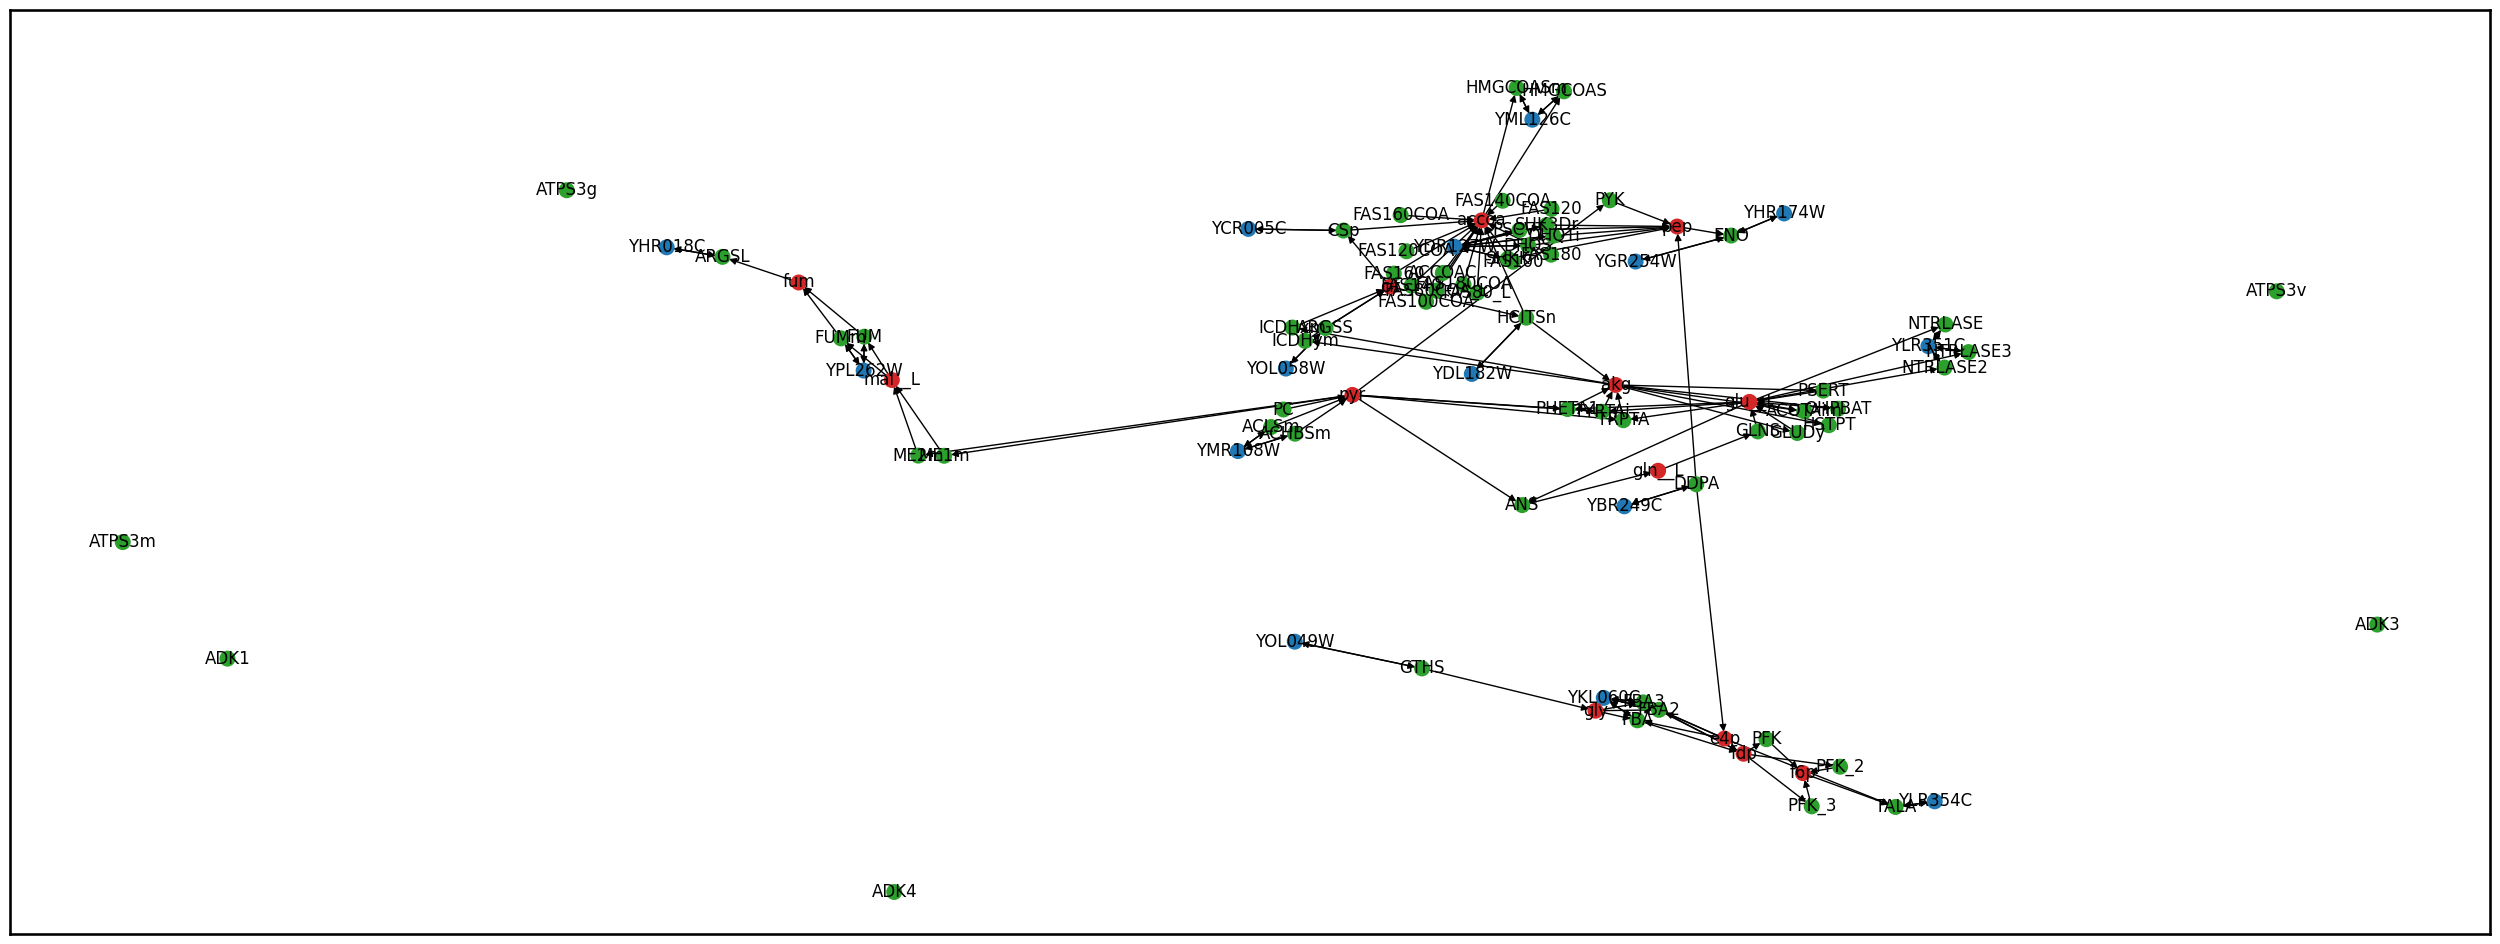

In [88]:
ENZYME_COLOR = "tab:blue"
METABOLITE_COLOR = "tab:red"
REACTION_COLOR = "tab:green"
def get_color(G, node):
    layer = G.nodes[node]['layer']
    if layer == 2:
        return METABOLITE_COLOR   
    elif layer == 1:
        return REACTION_COLOR
    elif layer == 0:
        return ENZYME_COLOR

def get_enzymes_from_path(path):
    enzyme_ids = []
    _t = reaction_metabolite_enzyme.to_frame()
    for node in path:
        enzyme_ids.extend(_t[_t['reaction_id'] == node]['enzyme_id'].values.tolist())
    return enzyme_ids

def filter_explanation_enzymes(nodes, valid_enzymes):
    return [node for node in nodes if node in valid_enzymes]

path = ['pyr', 'ME1m', 'mal__L', 'FUMm', 'fum', 'ARGSL', 'YHR018C']

valid_enzymes = explanation_df[(explanation_df['metabolite_id'] == metabolite_id)]['exp_enzymes'].values.tolist()

nodes = []
for path in all_paths:
    nodes = nodes + path + filter_explanation_enzymes(get_enzymes_from_path(path), valid_enzymes)

nodes = set(nodes)

nodes.remove('atp')
nodes.remove('adp')
nodes.remove('amp')

print(nodes)

G_prime = G_raw.subgraph(nodes)
pos = nx.fruchterman_reingold_layout(G_prime)
fig, ax0 = plt.subplots(1, 1, figsize=(32, 12))
nx.draw_networkx(
    G_prime,
    pos = pos,
    node_size=100,
    node_color=[get_color(G_prime, node) for node in G_prime],
    with_labels=True,
    ax=ax0,
)

In [63]:
all_paths = []
metabolite_id = 'pyr'
for target_enzyme in df[df['metabolite_id'] == metabolite_id].loc[:, 'exp_enzymes'].values:
    if target_enzyme in G_raw:
        if nx.has_path(G_raw, source=metabolite_id, target=target_enzyme):
            paths = list(nx.all_shortest_paths(G_raw, source=metabolite_id, target=target_enzyme))
            for path in paths:
                print(path)
                all_paths.append(path)
        elif nx.has_path(G_raw, target=metabolite_id, source=target_enzyme):
            paths = list(nx.all_shortest_paths(G_raw, target=metabolite_id, source=target_enzyme))
            for path in paths:
                print(path)
                all_paths.append(path)

['YBR249C', 'DDPA', 'e4p', 'FBA3', 'fdp', 'PFK', 'atp', 'PYK', 'adp', 'PC', 'pyr']
['YBR249C', 'DDPA', 'e4p', 'FBA', 'fdp', 'PFK', 'atp', 'PYK', 'adp', 'PC', 'pyr']
['YBR249C', 'DDPA', 'e4p', 'FBA2', 'fdp', 'PFK', 'atp', 'PYK', 'adp', 'PC', 'pyr']
['YBR249C', 'DDPA', 'e4p', 'FBA3', 'fdp', 'PFK_2', 'atp', 'PYK', 'adp', 'PC', 'pyr']
['YBR249C', 'DDPA', 'e4p', 'FBA', 'fdp', 'PFK_2', 'atp', 'PYK', 'adp', 'PC', 'pyr']
['YBR249C', 'DDPA', 'e4p', 'FBA2', 'fdp', 'PFK_2', 'atp', 'PYK', 'adp', 'PC', 'pyr']
['YBR249C', 'DDPA', 'e4p', 'FBA3', 'fdp', 'PFK_3', 'atp', 'PYK', 'adp', 'PC', 'pyr']
['YBR249C', 'DDPA', 'e4p', 'FBA', 'fdp', 'PFK_3', 'atp', 'PYK', 'adp', 'PC', 'pyr']
['YBR249C', 'DDPA', 'e4p', 'FBA2', 'fdp', 'PFK_3', 'atp', 'PYK', 'adp', 'PC', 'pyr']
['YBR249C', 'DDPA', 'e4p', 'FBA3', 'fdp', 'PFK', 'atp', 'ATPS3m', 'adp', 'PC', 'pyr']
['YBR249C', 'DDPA', 'e4p', 'FBA', 'fdp', 'PFK', 'atp', 'ATPS3m', 'adp', 'PC', 'pyr']
['YBR249C', 'DDPA', 'e4p', 'FBA2', 'fdp', 'PFK', 'atp', 'ATPS3m', 'adp', 

In [18]:
window_size = 3
[
    [
        path[i:i+window_size] 
        for i in range(len(path) - window_size + 1)
        for path in r
        if len(r)
    ]
    for target_enzyme in df[df['metabolite_id'] == 'pyr'].loc[:, 'exp_enzymes'].values
    if target_enzyme in G_raw
    if (r := list(nx.all_shortest_paths(G_raw, source='pyr', target=target_enzyme)))
]

NetworkXNoPath: Target YBR249C cannot be reached from given sources

In [ ]:
for target_enzyme in df[df['metabolite_id'] == 'pyr'].loc[:, 'exp_enzymes'].values:
    if target_enzyme in G_raw:
        print(list(nx.all_shortest_paths(G_raw, source='pyr', target=target_enzyme)))

[['pyr', 'PYK', 'pep', 'DDPA', 'YBR249C']]
[['pyr', 'PC', 'oaa', 'CSp', 'YCR005C'], ['pyr', 'TYRTAi', 'oaa', 'CSp', 'YCR005C'], ['pyr', 'PDHm', 'accoa', 'CSp', 'YCR005C'], ['pyr', 'THFATm', 'accoa', 'CSp', 'YCR005C'], ['pyr', 'GCC2cm_copy2', 'accoa', 'CSp', 'YCR005C'], ['pyr', 'AKGDbm', 'accoa', 'CSp', 'YCR005C'], ['pyr', 'AKGDam', 'accoa', 'CSp', 'YCR005C'], ['pyr', 'GCC2am', 'accoa', 'CSp', 'YCR005C'], ['pyr', 'GCCcm', 'accoa', 'CSp', 'YCR005C'], ['pyr', 'GLYCLm', 'accoa', 'CSp', 'YCR005C'], ['pyr', 'GCC2cm_copy1', 'accoa', 'CSp', 'YCR005C'], ['pyr', 'GCCam', 'accoa', 'CSp', 'YCR005C'], ['pyr', 'GCC2bim', 'accoa', 'CSp', 'YCR005C'], ['pyr', 'GCCbim', 'accoa', 'CSp', 'YCR005C']]
[['pyr', 'PDHm', 'accoa', 'HCITSn', 'YDL182W'], ['pyr', 'THFATm', 'accoa', 'HCITSn', 'YDL182W'], ['pyr', 'GCC2cm_copy2', 'accoa', 'HCITSn', 'YDL182W'], ['pyr', 'AKGDbm', 'accoa', 'HCITSn', 'YDL182W'], ['pyr', 'AKGDam', 'accoa', 'HCITSn', 'YDL182W'], ['pyr', 'GCC2am', 'accoa', 'HCITSn', 'YDL182W'], ['pyr', 'GCC

In [ ]:
import escher
from escher import Builder

builder = Builder(
    map_name='e_coli_core.Core metabolism',
    model_name='e_coli_core',
)

builder.highlight_missing = True
builder

Builder(highlight_missing=True)

# Shap analysis

In [ ]:
from shap import KernelExplainer, kmeans, Explanation
from shap.plots import beeswarm

Trying to unpickle estimator RobustScaler from version 1.1.3 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator Pipeline from version 1.1.3 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator ColumnTransformer from version 1.1.3 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator ElasticNet from version 1.1.3 when using version 1.1.1. This might lead to breaking code or invalid results. Use at

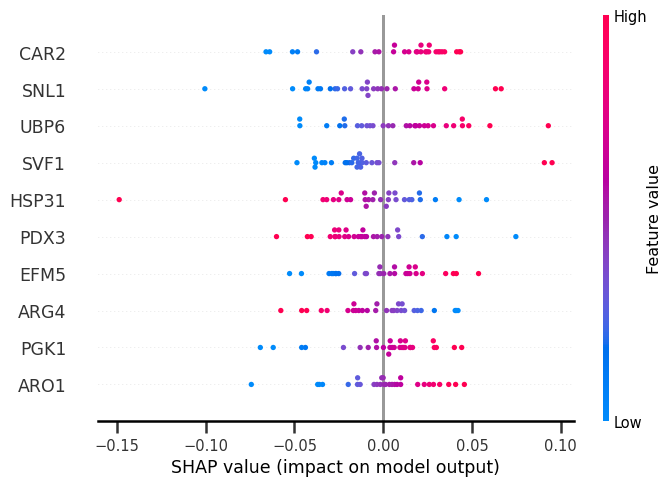

In [ ]:
fig = set_context(MODE)
ax0 = fig.add_subplot(1, 1, 1)

metabolite_id = 'pyr'
strategy = Strategy.METABOLITE_CENTRIC
tier = Tier.TIER0
shap_explanations = get_shap_df(tier=tier, strategy=strategy)
model = load_model(tier=tier, strategy=strategy, metabolite=metabolite_id)

selected_feature_names = [x.replace('num__', '') for x in model.regressor_[:-1].get_feature_names_out()]
protein_info = pd.read_json("/home/tvangraft/tudelft/thesis/metaengineering/data/training/gene_annotation.json").T.explode('gene_prefered_name').reset_index(names=['orf'])
explanation = Explanation(shap_explanations[metabolite_id], feature_names=protein_info[protein_info['orf'] == selected_feature_names]['gene_prefered_name'].values.tolist())
explanation[:, :20]

vals = np.abs(explanation.values).mean(0)
order = np.argsort((-vals))
beeswarm(explanation[:, order][:, :10], max_display=10, show=False)
save_fig(path=f'./images/{MODE}/explanation/', name="pyruvate_single_metabolite_tier_0_explanation")